<a href="https://colab.research.google.com/github/Nastarii/Shopee-Price-Match-Guarantee/blob/main/Shopee_Product_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Project

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c shopee-product-matching

shopee-product-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq shopee-product-matching.zip

In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 10.0 MB/s eta 0:00:00


**Sugestion:** Store the date from product registration can improve the model

# Read Data

In [ ]:
from unidecode import unidecode
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

train_images, train_df = os.listdir('./train_images'), pd.read_csv('./train.csv')
test_images, test_df = os.listdir('./test_images'), pd.read_csv('./test.csv')

print(f'Dataset samples amount: ({len(train_images)}, {len(test_images)})')

Dataset samples amount: (32412, 3)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [ ]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


# Resample Dataset

Our goal is create a new dataset with the input data from 2 products and train some model that will identify if it's a duplicated product or not

In [ ]:
#@title Preprocessing
train_df['title'] = train_df['title'].apply(lambda x: unidecode(x))
train_df['title'] = train_df['title'].str.lower()

train_df.set_index('label_group', inplace=True)
train_df

,posting_id,image,image_phash,title
label_group,,,,
249114794,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,paper bag victoria secret
2937985045,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"double tape 3m vhb 12 mm x 4,5 m original / do..."
2395904891,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,maling tts canned pork luncheon meat 397 gr
4093212188,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,daster batik lengan pendek - motif acak / camp...
3648931069,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,nescafe \xc3\x89clair latte 220ml
...,...,...,...,...
3776555725,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,masker bahan kain spunbond non woven 75 gsm 3 ...
2736479533,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,mamypoko pants royal soft - s 70 - popok celana
4101248785,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,khanzaacc robot re101s 1.2mm subwoofer bass me...


In [ ]:
df = pd.DataFrame([],columns=[f"{col}_{int(idx/len(train_df.columns))}" for idx, col in enumerate([*train_df.columns] * 2)])

print('Progress:\n')

for i in tqdm(train_df.index):
    # Separate Samples
    repeated_products = train_df.loc[i]
    
    stack_df = pd.DataFrame(repeated_products.stack().reset_index(drop=True)).T
    
    while len(stack_df.columns) > 8:

        subset_df = stack_df.iloc[:, :len(train_df.columns) * 2]
        subset_df.columns = df.columns

        df = pd.concat([df, subset_df], ignore_index=True)
        stack_df = stack_df.iloc[:, 4:]

    stack_df.columns = df.columns
    df = pd.concat([df, stack_df], ignore_index=True)

Progress:



  0%|          | 0/34250 [00:00<?, ?it/s]

In [ ]:
columns_names = [f"{col}_{int(idx/len(train_df.columns))}" for idx, col in enumerate([*train_df.columns] * 2)]
non_df = pd.DataFrame([],columns=columns_names)

for i in tqdm(range(20)):

    non_duplicates = train_df.reset_index().drop_duplicates(subset='label_group').set_index('label_group').values.reshape(int(11014/2),8)

    non_df = pd.concat([non_df, pd.DataFrame(non_duplicates,columns=columns_names).sample(frac=1)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
non_df['duplicates'] = 0
df['duplicates'] = 1

df = pd.concat([df,non_df.iloc[:len(df)]],axis=0)
df.to_csv('shopee_dataset.csv')

# Preprocessing Data

In [ ]:
df = pd.read_csv('shopee_dataset.csv').sample(frac=1)

In [ ]:
input_names = ['image_phash_0', 'title_0', 'image_phash_1', 'title_1']
df['concatenated'] = df[input_names].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

X, y  = df['concatenated'], df['duplicates']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents and transform the documents into TF-IDF features
X = vectorizer.fit_transform(X)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.32730	validation_1-error:0.32852
[1]	validation_0-error:0.31761	validation_1-error:0.31864
[2]	validation_0-error:0.29352	validation_1-error:0.29530
[3]	validation_0-error:0.28156	validation_1-error:0.28321
[4]	validation_0-error:0.28138	validation_1-error:0.28289
[5]	validation_0-error:0.27176	validation_1-error:0.27419
[6]	validation_0-error:0.26348	validation_1-error:0.26515
[7]	validation_0-error:0.25814	validation_1-error:0.25940
[8]	validation_0-error:0.25266	validation_1-error:0.25444
[9]	validation_0-error:0.25050	validation_1-error:0.25191
[10]	validation_0-error:0.24858	validation_1-error:0.24997
[11]	validation_0-error:0.24758	validation_1-error:0.24917
[12]	validation_0-error:0.23568	validation_1-error:0.23637
[13]	validation_0-error:0.23666	validation_1-error:0.23880
[14]	validation_0-error:0.22815	validation_1-error:0.23031
[15]	validation_0-error:0.22211	validation_1-error:0.22443
[16]	validation_0-error:0.21819	validation_1-error:0.22060
[17]	va

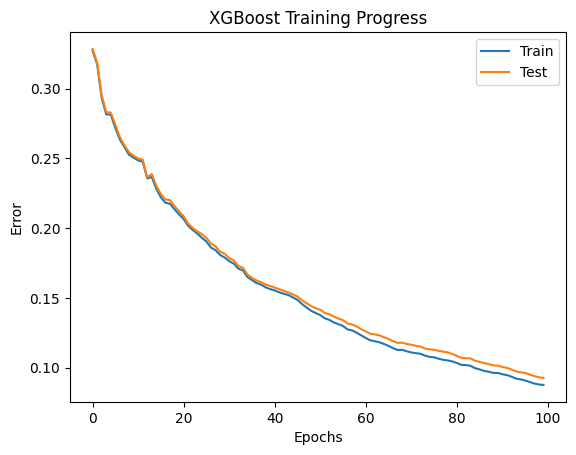

Accuracy: 0.9073922000835603


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create an instance of the Classifier
model = xgb.XGBClassifier()

# Train the classifier on the training data and track the evaluation metrics
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric="error", verbose=True)

# Plot the training progress
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('XGBoost Training Progress')
plt.show()

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

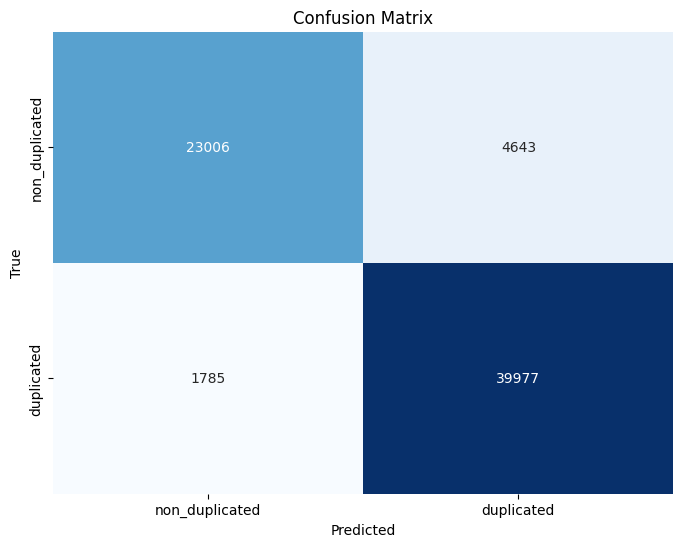

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

column_names = ['non_duplicated', 'duplicated']
# Set x-axis and y-axis ticks and labels
plt.xticks(ticks=[i + 0.5 for i in range(len(column_names))], labels=column_names, rotation=0)
plt.yticks(ticks=[i + 0.5 for i in range(len(column_names))], labels=column_names, rotation=90)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model to a file
model.save_model('xgboost_model.model')

# Clustering

The trained algorithm has a pretty good accuracy, however compare with every product in platform can produces an acumulative error and reduces the model performance, now the objective is find patterns with unsupervised learning. In that way, we can use our model only in samples that has the sames patterns and improve our performance.

In [ ]:
cluster_df = train_df[['image_phash','title']].reset_index()

For n_clusters = 2, the silhouette score is 0.001310455951907137
For n_clusters = 3, the silhouette score is 0.001580824474959057
For n_clusters = 4, the silhouette score is 0.001799745850491886
For n_clusters = 5, the silhouette score is 0.002376166932739232
For n_clusters = 6, the silhouette score is 0.0025260090673919645
For n_clusters = 7, the silhouette score is 0.0028764320260906925
For n_clusters = 8, the silhouette score is 0.0033294502359484564
For n_clusters = 9, the silhouette score is 0.0038018540703194745
For n_clusters = 10, the silhouette score is 0.00407825824501732
The best number of clusters is 10 with a silhouette score of 0.00407825824501732


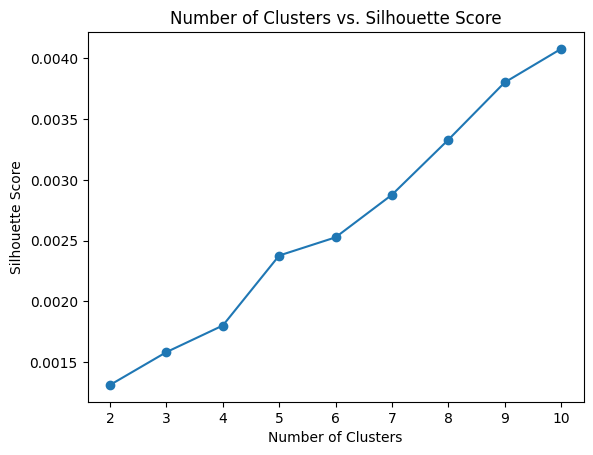

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create an instance of the KMeans clustering algorithm
kmeans = KMeans(n_clusters=10, n_init=10)

# Join columns
X = cluster_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents and transform the documents into TF-IDF features
X = vectorizer.fit_transform(X)


# Initialize variables to store best silhouette score and corresponding number of clusters
best_score = -1
best_clusters = -1

# Initialize lists to store the number of clusters and corresponding silhouette scores
num_clusters = []
silhouette_scores = []

# Try different numbers of clusters
for n_clusters in range(2, 11):
    # Create an instance of the KMeans clustering algorithm
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    
    # Fit the model to the scaled data
    kmeans.fit(X)
    
    # Get the cluster labels for each data point
    labels = kmeans.labels_
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, labels)
    
    # Print the silhouette score for the current number of clusters
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")
    
    # Append the number of clusters and silhouette score to the lists
    num_clusters.append(n_clusters)
    silhouette_scores.append(silhouette_avg)

    # Check if the current score is better than the previous best score
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_clusters = n_clusters

# Print the best number of clusters
print(f"The best number of clusters is {best_clusters} with a silhouette score of {best_score}")

# Plot the number of clusters vs. silhouette scores
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Number of Clusters vs. Silhouette Score')
plt.show()

In [ ]:
# Create an instance of the KMeans clustering algorithm
kmeans = KMeans(n_clusters=45, n_init=10)

# Fit the model to the scaled data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, labels)
    

In [ ]:
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.012569398832117672
